In [ ]:
import pandas as pd
import numpy as np


In [ ]:
from google.colab import files

uploaded = files.upload()




Saving Infected_Data.csv to Infected_Data (2).csv


In [ ]:
df = pd.read_csv("Infected_Data.csv")

In [ ]:
df.head()

,ID,Fever,Cough,Breathing Issues,Infected
0,1,N,N,N,N
1,2,Y,Y,Y,Y
2,3,Y,Y,N,N
3,4,Y,N,Y,Y
4,5,Y,Y,Y,Y


In [ ]:
df.drop("ID",axis = 1,inplace=True)
df

,Fever,Cough,Breathing Issues,Infected
0,N,N,N,N
1,Y,Y,Y,Y
2,Y,Y,N,N
3,Y,N,Y,Y
4,Y,Y,Y,Y
5,N,Y,N,N
6,Y,N,Y,Y
7,Y,N,Y,Y
8,N,Y,Y,Y
9,Y,Y,N,Y


In [ ]:


def entropy(col):

    unique_values, counts = np.unique(col, return_counts=True)


    prob = counts / counts.sum()

    entropy_value = 0
    for p in prob:
        if p > 0:
            entropy_value  = entropy_value -  p * np.log2(p)

    return entropy_value


In [ ]:


def info_gain(data, feat, tar):

    total_entropy = entropy(data[tar])


    values, counts = np.unique(data[feat], return_counts=True)

    weighted_entropy = 0
    for i, value in enumerate(values):
        subset = data[data[feat] == value]
        subset_entropy = entropy(subset[tar])
        weight = counts[i] / counts.sum()
        weighted_entropy =      weighted_entropy+ weight * subset_entropy


    gain = total_entropy - weighted_entropy
    return gain


In [ ]:
def build_tree(data, attributes, target):

    if len(np.unique(data[target])) == 1:
        return np.unique(data[target])[0]

    if len(attributes) == 0:
        return data[target].mode()[0]

    gains = [info_gain(data, attr, target) for attr in attributes]
    best_attr = attributes[np.argmax(gains)]

    tree = {best_attr: {}}
    for value in np.unique(data[best_attr]):
        subset = data[data[best_attr] == value]
        if subset.shape[0] == 0:
            tree[best_attr][value] = data[target].mode()[0]
        else:
            new_attrs = [attr for attr in attributes if attr != best_attr]
            tree[best_attr][value] = build_tree(subset, new_attrs, target)
    return tree





In [ ]:
def build_tree(df, features, target):
    if len(features) == 0:
        return df[target].mode()[0]
    feature = features[0]
    tree = {}
    for value in df[feature].unique():
        subset = df[df[feature] == value]
        tree[value] = build_tree(subset, features[1:], target)
    return {feature: tree}


features = list(df.columns[:-1])
target = df.columns[-1]
tree = build_tree(df, features, target)


In [ ]:
def print_tree(tree, indent=""):
    if not isinstance(tree, dict):
        print(indent + "-> " + str(tree))
        return
    for attr, branches in tree.items():
        print(indent + attr + "?")
        for val, sub in branches.items():
            print(indent + f"|--{val}")
            print_tree(sub, indent + "  ")

print_tree(tree)


Fever?
|--N
  Cough?
  |--N
    Breathing Issues?
    |--N
      -> N
  |--Y
    Breathing Issues?
    |--N
      -> N
    |--Y
      -> Y
|--Y
  Cough?
  |--Y
    Breathing Issues?
    |--Y
      -> Y
    |--N
      -> N
  |--N
    Breathing Issues?
    |--Y
      -> Y


In [ ]:
from math import log2
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

In [ ]:
X = df.drop(columns=[target])
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
X = X.replace({"Yes": 1, "No": 0, "Y": 1, "N": 0})
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3, random_state=42)
clf.fit(X, y)


/tmp/ipython-input-186914932.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.replace({"Yes": 1, "No": 0, "Y": 1, "N": 0})


DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)

|--- Breathing Issues <= 0.50
|   |--- Fever <= 0.50
|   |   |--- class: N
|   |--- Fever >  0.50
|   |   |--- class: N
|--- Breathing Issues >  0.50
|   |--- Fever <= 0.50
|   |   |--- class: Y
|   |--- Fever >  0.50
|   |   |--- class: Y



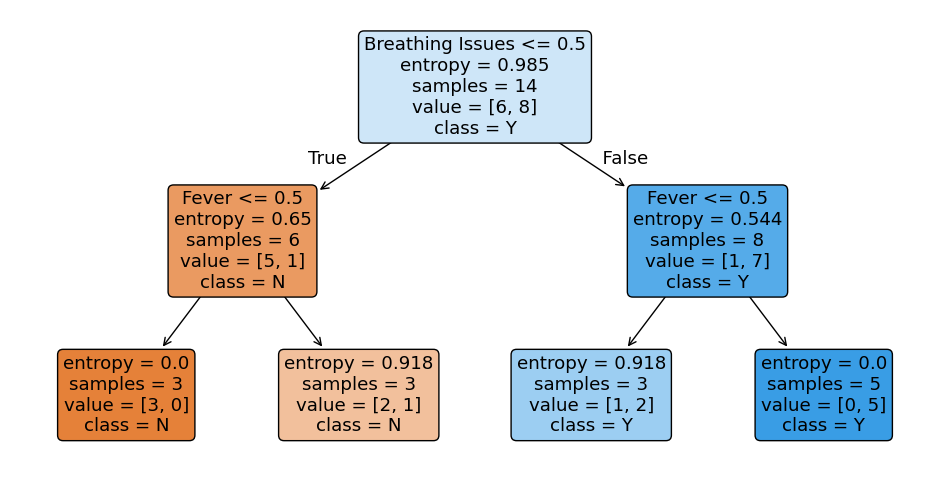

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
print(export_text(clf, feature_names=list(X.columns)))

# Draw tree
plt.figure(figsize=(12,6))
plot_tree(clf, feature_names=X.columns, class_names=clf.classes_, filled=True, rounded=True)
plt.show()


In [ ]:
X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

custom_tree = build_tree(pd.concat([X_train, y_train], axis=1), list(X.columns), target)
y_pred_scratch = X_test.apply(lambda row: predict_tree(row, custom_tree), axis=1)
print("Accuracy:", accuracy_score(y_test, y_pred_scratch))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_scratch))

Accuracy: 0.6666666666666666
Confusion Matrix:
 [[1 0]
 [1 1]]
